In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
import sys
import json
import gc
from matplotlib import pyplot as plt

warnings.simplefilter('ignore')

In [3]:
basedir = Path().resolve().parent
logdir = basedir / "logs"
datadir = basedir / "data"

In [4]:
train = pd.read_csv(datadir / "train_RC_kfold10_seed42.csv", index_col=0)
train = train[(np.arange(train.shape[0]) % 80) < 35].reset_index(drop=True)
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,RC,kfold
0,1,1,20,50,0.000000,0.083334,0,5.837492,20_50,4
1,2,1,20,50,0.033652,18.383041,0,5.907794,20_50,4
2,3,1,20,50,0.067514,22.509278,0,7.876254,20_50,4
3,4,1,20,50,0.101542,22.808822,0,11.742872,20_50,4
4,5,1,20,50,0.135756,25.355850,0,12.234987,20_50,4


In [5]:
pressure = train.pressure.values.squeeze().reshape(-1,1).astype('float32')
P_MIN = np.min(pressure)
P_MAX = np.max(pressure)
P_STEP = (pressure[1] - pressure[0])[0]
print('Min pressure: {}'.format(P_MIN))
print('Max pressure: {}'.format(P_MAX))
print('Pressure step: {}'.format(P_STEP))
print('Unique values:  {}'.format(np.unique(pressure).shape[0]))

del pressure
gc.collect()

Min pressure: -1.8957443237304688
Max pressure: 64.82099151611328
Pressure step: 0.07030248641967773
Unique values:  950


18

In [6]:
def score(y_true, y_pred, u_out):
    mae = (1 - u_out) * np.abs(y_true - y_pred)
    mae = np.sum(mae) / np.sum(1 - u_out)
    return mae


def do_stair(y):
    y = np.round((y - P_MIN) / P_STEP) * P_STEP + P_MIN
    y = np.clip(y, P_MIN, P_MAX)
    return y

In [7]:
expts = [
    "custom2", "lstm-batchnorm", "lstm-less-addfeatures-cut-large-custom-mae",
    "lstm-less-addfeatures-cut-large-custom-mae", "lstm-notcut",
    "lstm-rcpred", "lstm-reliable", "lstm-soft", "lstm-soft-fullconnect",
    "lstm-soft-rc", "lstm-soft-fullconnect-dropout"
]

In [8]:
valid_preds = []
cols = [str(i) for i in range(35)]

for expt in expts:
    vp = pd.read_csv(logdir / expt / "valid_preds.csv")
    vp = vp[cols].values.reshape(-1)
    vp = do_stair(vp)
    valid_preds.append(vp)

valid_preds = np.vstack(valid_preds)

0.2109074592590332


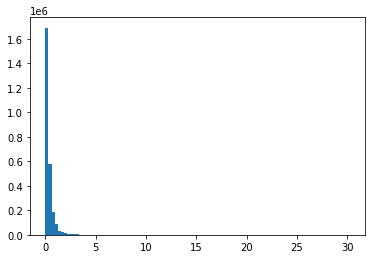

In [18]:
spread = np.max(valid_preds, axis=0) - np.min(valid_preds, axis=0)
print(np.median(spread))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(spread, bins=100)
plt.show()

In [11]:
targets = train["pressure"].values
kfolds = train["kfold"].values
u_outs = train["u_out"].values

## baselines

In [21]:
print(f"Single: {score(targets, valid_preds[expts.index('lstm-soft')], u_outs):.03f}")

# median
pred_median = do_stair(np.median(valid_preds, axis=0))
print(f"Median: {score(targets, pred_median, u_outs):.03f}")

# mean
pred_mean = do_stair(np.mean(valid_preds, axis=0))
print(f"Mean: {score(targets, pred_mean, u_outs):.03f}")

Single: 0.165
Median: 0.146
Mean: 0.148


In [24]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

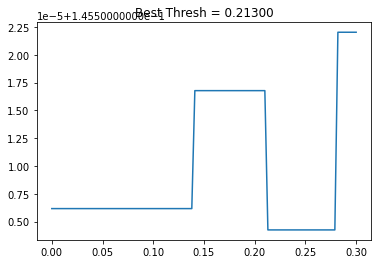

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

threshs = np.linspace(0, 0.3, 101)
scores = []
for thresh in threshs:
    pred_custom = np.where(spread < thresh, pred_mean, pred_median)
    pred_custom = do_stair(pred_custom)
    scores.append(score(targets, pred_custom, u_outs))
ax.plot(threshs, scores)
ax.set_title(f"Best Thresh = {threshs[np.argmin(scores)]:.05f}")
plt.show()

In [37]:
submissions = []

for expt in expts:
    print(expt)
    sub = pd.read_csv(logdir / expt / "custom_submission.csv")
    sub = do_stair(sub["pressure"].values)
    submissions.append(sub)

submissions = np.vstack(submissions)

custom2
lstm-batchnorm
lstm-less-addfeatures-cut-large-custom-mae
lstm-less-addfeatures-cut-large-custom-mae
lstm-notcut
lstm-rcpred
lstm-reliable
lstm-soft
lstm-soft-fullconnect
lstm-soft-rc
lstm-soft-fullconnect-dropout


In [41]:
# Median Submission
submission = pd.read_csv(datadir / "sample_submission.csv")
sub_median = do_stair(np.median(submissions, axis=0))
sub_mean = do_stair(np.mean(submissions, axis=0))
sub_spread = np.max(submissions, axis=0) - np.min(submissions, axis=0)

sub_custom = do_stair(np.where(sub_spread < 0.213, sub_mean, sub_median))

submission["pressure"] = sub_custom
submission.to_csv(basedir /  "custom_submission.csv", index=False)
submission.head()

,id,pressure
0,1,6.259344
1,2,5.978134
2,3,7.102974
3,4,7.665394
4,5,9.141746


## CNN

In [131]:
from sklearn.preprocessing import Normalizer

import tensorflow as tf
from tensorflow import keras

In [153]:
# def create_features(preds):
#     pred_cols = [f"pred{i}" for i in range(preds.shape[0])]
#     df = pd.DataFrame(preds.T, columns=pred_cols)
#     df["median"] = np.median(df[pred_cols], axis=1)
#     df["mean"] = np.mean(df[pred_cols], axis=1)

#     q25, q75 = np.quantile(df[pred_cols], [0.25, 0.75], axis=1)
#     iqr = q75 - q25
#     df["iqr"] = iqr

#     for c in pred_cols:
#         df[c] = df[c] - df["median"]
        
#     return df


def create_features(preds):
    pred_cols = [f"pred{i}" for i in range(preds.shape[0])]
    df = pd.DataFrame(preds.T, columns=pred_cols)
    df["median"] = np.median(df[pred_cols], axis=1)
    df["mean"] = np.mean(df[pred_cols], axis=1)

#     q25, q75 = np.quantile(df[pred_cols], [0.25, 0.75], axis=1)
#     iqr = q75 - q25
#     df["iqr"] = iqr

#     for c in pred_cols:
#         df[c] = df[c] - df["median"]
        
    return df

train_df = create_features(valid_preds)
test_df = create_features(submissions)

In [154]:
class Normalizer:
    def __init__(self):
        self.pred_cols = [f"pred{i}" for i in range(10)]
        self.other_cols = []
        self.minmax = {}
    
    def fit_transform(self, df_):
        df = df_.copy()
        cols = list(df.columns)
        self.other_cols = [c for c in cols if c not in self.pred_cols]
        
        x = df[self.pred_cols].values
        self.minmax["pred"] = (np.min(x), np.max(x))
        x = (x - self.minmax["pred"][0]) / (self.minmax["pred"][1] - self.minmax["pred"][0])
        df[self.pred_cols] = x
        
        for c in self.other_cols:
            x = df[c].values
            self.minmax[c] = (np.min(x), np.max(x))
            x = (x - self.minmax[c][0]) / (self.minmax[c][1] - self.minmax[c][0])
            df[c] = x
        
        return df[self.pred_cols + self.other_cols].values
        
    
    def transform(self, df_):
        df = df_.copy()
        
        df[self.pred_cols] = (df[self.pred_cols].values - self.minmax["pred"][0]) / (self.minmax["pred"][1] - self.minmax["pred"][0])
        for c in self.other_cols:
            df[c] = (df[c].values - self.minmax["pred"][0]) / (self.minmax["pred"][1] - self.minmax["pred"][0])
        
        return df[self.pred_cols + self.other_cols].values

In [155]:
SCL = Normalizer()

train_data = SCL.fit_transform(train_df)
test_data = SCL.transform(test_df)

In [159]:
# def build_model(n_features) -> keras.models.Sequential:
#     model = keras.models.Sequential([keras.layers.Input(shape=(n_features, ))])
    
#     for n_unit in [64]:
#         model.add(keras.layers.Dense(n_unit, activation="relu"))
#     model.add(keras.layers.Dense(1))

#     model.compile(
#         optimizer=keras.optimizers.Adam(lr=1e-3),
#         loss='mae')
#     return model


def build_model(n_features) -> keras.models.Sequential:
    model = keras.models.Sequential([keras.layers.Input(shape=(n_features, 35))])
    model.add(
        keras.layers.Conv1D(filters=32, kernel_size=3, dilation_rate=1, padding="valid")
    )
    model.add(
        keras.layers.Conv1D(filters=16, kernel_size=3, dilation_rate=1, padding="valid")
    )
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(35))

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss='mae')
    return model

In [160]:
train_data = train_data.reshape(-1, 35, train_data.shape[-1]).transpose(0, 2, 1)
targets = targets.reshape(-1, 35)
# test_data = test_data.reshape(-1, 35, test_data.shape[-1])

In [161]:
EPOCHS = 50
BATCH_SIZE = 512

with tf.device(f"/GPU:{2}"):
    for fold in range(10):
        print("-" * 15, ">", f"Fold {fold+1}", "<", "-" * 15)
        train_idx, valid_idx = (kfolds[0::35] != fold), (kfolds[0::35] == fold)
        X_train, X_valid = train_data[train_idx, :, :], train_data[valid_idx, :, :]
        y_train, y_valid = targets[train_idx], targets[valid_idx]
        
        es = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            verbose=1,
            mode="min",
            restore_best_weights=True,
        )

        model = build_model(n_features=X_train.shape[-1])
        model.summary()
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[es],
            verbose=1
        )
        
        # print(f"Median: {score(targets[valid_idx], pred_median[valid_idx], u_outs[valid_idx]):.04f}")
        
        del model, X_train, X_valid, y_train, y_valid
        keras.backend.clear_session()
        
        break

--------------- > Fold 1 < ---------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 33, 32)            3392      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31, 16)            1552      
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 16)            64        
_________________________________________________________________
re_lu (ReLU)                 (None, 31, 16)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 35)                595       
Total params: 5,603
Trainable params: 5,571
Non-trainable params: 32
__________

In [116]:
pred_median = np.median(valid_preds, axis=0)
print(f"Median: {score(targets[valid_idx], pred_median[valid_idx], u_outs[valid_idx]):.04f}")

Median: 0.1433


In [130]:
for pred in valid_preds:
    print(f"Median: {score(targets, pred, u_outs):.04f}")
print(f"Median: {score(targets, pred_median, u_outs):.04f}")

Median: 0.1654
Median: 0.1882
Median: 0.1638
Median: 0.1638
Median: 0.1711
Median: 0.1658
Median: 0.1651
Median: 0.1647
Median: 0.1676
Median: 0.1690
Median: 0.1456
